In [9]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [11]:
import argparse
import logging
import pickle
import random

import torch
import numpy as np

import tvm
from tvm.auto_scheduler.utils import to_str_round
from tvm.auto_scheduler.cost_model import RandomModelInternal

sys.path.append("/root/work/tenset/scripts")
from common import load_and_register_tasks, str2bool
from train_model import train_zero_shot

from tvm.auto_scheduler.dataset import Dataset, LearningTask
from tvm.auto_scheduler.cost_model.xgb_model import XGBModelInternal
from tvm.auto_scheduler.cost_model.mlp_model import MLPModelInternal
from tvm.auto_scheduler.cost_model.lgbm_model import LGBModelInternal
from tvm.auto_scheduler.cost_model.tabnet_model import TabNetModelInternal
from tvm.auto_scheduler.cost_model.metric import (
    metric_rmse,
    metric_r_squared,
    metric_pairwise_comp_accuracy,
    metric_top_k_recall,
    metric_peak_score,
    metric_mape,
    random_mix,
)

load_and_register_tasks()
dataset = pickle.load(open("../../dataset_30.pkl", "rb"))
train_set, test_set = dataset.random_split_within_task(0.9)

tenset_model = MLPModelInternal()
tenset_model.fit_base(train_set, valid_set=test_set)

cuda:0
Fit a net. Train size: 104600
Epoch: 0	Batch: 204	Train Loss: 15.4014	Valid Loss: 63.0750	Train Speed: 90365
Epoch: 5	Batch: 204	Train Loss: 6.2050	Valid Loss: 36.7598	Train Speed: 80939
Epoch: 10	Batch: 204	Train Loss: 4.1274	Valid Loss: 23.2886	Train Speed: 85513
Epoch: 15	Batch: 204	Train Loss: 4.1495	Valid Loss: 19.1691	Train Speed: 71067
Epoch: 20	Batch: 204	Train Loss: 3.7388	Valid Loss: 18.0665	Train Speed: 84780
Epoch: 25	Batch: 204	Train Loss: 3.8193	Valid Loss: 15.7995	Train Speed: 88615
Epoch: 30	Batch: 204	Train Loss: 3.6524	Valid Loss: 17.2779	Train Speed: 83976
Epoch: 35	Batch: 204	Train Loss: 3.5582	Valid Loss: 16.2742	Train Speed: 81164
Epoch: 40	Batch: 204	Train Loss: 2.6633	Valid Loss: 17.7567	Train Speed: 74152
Epoch: 45	Batch: 204	Train Loss: 2.5166	Valid Loss: 13.5866	Train Speed: 84211
Epoch: 49	Batch: 204	Train Loss: 2.2281	Valid Loss: 13.9595	Train Speed: 76007


In [66]:
# SegmentDataLoader 패턴에 맞춰 데이터 준비
raw_features = list(dataset.features.values())[1:2]
raw_throughputs = list(dataset.throughputs.values())[1:2]

# 가변 길이 features와 labels를 리스트로 저장
features_list = []  # 각 샘플의 feature (seq_len, feature_dim)
costs = []
segment_sizes_list = []  # 각 샘플의 segment 길이
for raw_feature, raw_throughput in zip(raw_features, raw_throughputs):
    for feature, throughput in zip(raw_feature, raw_throughput):
        if feature.shape[0] != 1 and throughput > 1e-10 :  # segment 길이가 1이 아닌 것만
            features_list.append(feature)
            costs.append(-np.log(throughput))
            segment_sizes_list.append(feature.shape[0])

# numpy array로 변환
costs = np.array(costs, dtype=np.float32)
segment_sizes = np.array(segment_sizes_list, dtype=np.int32)

# 모든 features를 flatten (SegmentDataLoader 방식)
flatten_features = np.concatenate(features_list, axis=0).astype(np.float32)

print(f"총 샘플 수: {len(costs)}")
print(f"Flatten된 features shape: {flatten_features.shape}")
print(f"Segment sizes - Min: {segment_sizes.min()}, Max: {segment_sizes.max()}, Mean: {segment_sizes.mean():.2f}")

총 샘플 수: 3524
Flatten된 features shape: (14096, 164)
Segment sizes - Min: 4, Max: 4, Mean: 4.00


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentRegressionDataset:
    """SegmentDataLoader 패턴을 따르는 데이터셋"""
    def __init__(self, segment_sizes, features, labels, batch_size, device, 
                 fea_norm_vec=None, shuffle=False, seed=42):
        self.device = device
        self.shuffle = shuffle
        self.seed = seed
        self.number = len(labels)
        self.batch_size = batch_size
        
        self.segment_sizes = torch.tensor(segment_sizes, dtype=torch.int32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.features = torch.tensor(features, dtype=torch.float32)
        
        if fea_norm_vec is not None:
            self.normalize(fea_norm_vec)
        
        self.feature_offsets = (
            torch.cumsum(self.segment_sizes, 0, dtype=torch.int32) - self.segment_sizes
        ).cpu().numpy()
        
        self.iter_order = self.pointer = None
        self.rng = np.random.RandomState(seed)
    
    def normalize(self, norm_vector=None):
        if norm_vector is None:
            norm_vector = torch.ones((self.features.shape[1],))
            for i in range(self.features.shape[1]):
                max_val = self.features[:, i].max().item()
                if max_val > 0:
                    norm_vector[i] = max_val
        self.features /= norm_vector
        return norm_vector
    
    def __iter__(self):
        if self.shuffle:
            self.iter_order = torch.from_numpy(self.rng.permutation(self.number))
        else:
            self.iter_order = torch.arange(self.number)
        self.pointer = 0
        return self
    
    def __next__(self):
        if self.pointer >= self.number:
            raise StopIteration
        
        batch_indices = self.iter_order[self.pointer: self.pointer + self.batch_size]
        self.pointer += self.batch_size
        return self._fetch_indices(batch_indices)
    
    def _fetch_indices(self, indices):
        segment_sizes = self.segment_sizes[indices]
        
        feature_offsets = self.feature_offsets[indices]
        feature_indices = np.empty((segment_sizes.sum().item(),), dtype=np.int32)
        ct = 0
        for offset, seg_size in zip(feature_offsets, segment_sizes.numpy()):
            feature_indices[ct: ct + seg_size] = np.arange(offset, offset + seg_size, 1)
            ct += seg_size
        
        features = self.features[feature_indices]
        labels = self.labels[indices]
        return (x.to(self.device) for x in (segment_sizes, features, labels))
    
    def __len__(self):
        return self.number


# Train/Val 분할
n_samples = len(costs)
indices = np.arange(n_samples)
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=SEED)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features_list[i] for i in train_indices]
val_feature_list = [features_list[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)

print(f"훈련 샘플 수: {len(train_labels)}, 검증 샘플 수: {len(val_labels)}")
print(f"훈련 flatten features: {train_flatten_features.shape}")
print(f"검증 flatten features: {val_flatten_features.shape}")

# 정규화
fea_norm_vec = torch.ones((train_flatten_features.shape[1],))
for i in range(train_flatten_features.shape[1]):
    max_val = float(train_flatten_features[:, i].max())
    if max_val > 0:
        fea_norm_vec[i] = max_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = SegmentRegressionDataset(
    train_segment_sizes, train_flatten_features, train_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=True, seed=SEED
)
val_loader = SegmentRegressionDataset(
    val_segment_sizes, val_flatten_features, val_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=False, seed=SEED
)

X_train = train_flatten_features
X_val = val_flatten_features
y_train = train_labels
y_val = val_labels
train_dataset = train_loader
val_dataset = val_loader

훈련 샘플 수: 2819, 검증 샘플 수: 705
훈련 flatten features: (11276, 164)
검증 flatten features: (2820, 164)


## VAE Feature Pre-training (Reconstruction + β·KLD)

Feature만 입력으로 사용하여 VAE encoder representation을 먼저 학습합니다.
- Reconstruction loss: MSE로 원본 feature를 복원
- KL Divergence: latent 분포를 N(0, I)에 가깝게 정규화
- β 자동 탐색: 1e-3~1e-2 범위에서 최적값 탐색

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import r2_score
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentVAE(nn.Module):
    """
    Segment-level VAE:
    1. Segment Encoder: 각 row를 hidden_dim으로 변환
    2. Segment Sum: row들을 segment별로 합산
    3. VAE: 합산된 벡터를 encode → decode (reconstruction)
    """
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, dropout=0.1):
        super(SegmentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # ========== Segment Encoder (VAE 전에 적용) ==========
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # ========== VAE Encoder (segment sum 후 적용) ==========
        self.norm = nn.BatchNorm1d(hidden_dim)
        
        # Residual 레이어들
        self.l0 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.l1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VAE latent parameters
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # ========== VAE Decoder (hidden_dim으로 reconstruction) ==========
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # 출력: segment sum 벡터 (hidden_dim)
        )
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, h):
        """VAE Encoder: segment sum 벡터 → (mean, logvar)"""
        # BatchNorm
        h = self.norm(h)
        
        # Residual connections
        h = self.l0(h) + h
        h = self.l1(h) + h
        
        # Latent parameters
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        """VAE Decoder: latent z → reconstructed segment sum 벡터"""
        return self.decoder(z)
    
    def forward(self, segment_sizes, features):
        """
        Forward pass:
        1. Segment Encoder: features → hidden
        2. Segment Sum: hidden → segment-level 벡터
        3. VAE: encode → reparameterize → decode
        """
        # 1. Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # 2. Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        # 3. VAE Encode
        mean, logvar = self.encode(segment_sum_vec)
        
        # 4. Reparameterize
        z = self.reparameterize(mean, logvar)
        
        # 5. VAE Decode (reconstruct segment sum 벡터)
        recon = self.decode(z)  # (n_seg, hidden_dim)
        
        return mean, logvar, z, recon, segment_sum_vec


def vae_loss(recon, original, mean, logvar, beta):
    """
    VAE Loss = Reconstruction Loss + β * KL Divergence
    - Reconstruction: MSE between original and reconstructed segment sum 벡터
    - KLD: D_KL(q(z|x) || p(z)), where p(z) = N(0, I)
    """
    recon_loss = F.mse_loss(recon, original, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kld_loss
    return total_loss, recon_loss, kld_loss


print("Segment VAE 모델 정의 완료!")
print(f"- Input dim: {train_flatten_features.shape[1]}")
print(f"- Hidden dim: 256")
print(f"- Latent dim: 64")
print("Flow: features → segment_encoder → segment_sum → VAE (encode/decode)")

Segment VAE 모델 정의 완료!
- Input dim: 164
- Hidden dim: 256
- Latent dim: 64
Flow: features → segment_encoder → segment_sum → VAE (encode/decode)


In [92]:
# 하이퍼파라미터 탐색을 위한 VAE 학습 함수
# KL/latent_dim이 0.05~0.2 범위에 있도록 우선 조정
from itertools import product

def train_vae_single_config(train_loader, val_loader, input_dim, device,
                            hidden_dim, latent_dim, beta, lr, dropout=0.1,
                            num_epochs=100, patience=40, verbose=False):
    """단일 설정으로 VAE 학습"""
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    
    model = SegmentVAE(input_dim, hidden_dim, latent_dim, dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)
    
    best_recon_r2 = -float('inf')
    patience_counter = 0
    best_state = None
    history = {'recon_r2': [], 'kl_per_dim': [], 'recon_loss': []}
    
    for epoch in range(num_epochs):
        model.train()
        epoch_kl = 0.0
        epoch_recon = 0.0
        n_batches = 0
        
        for segment_sizes_batch, features_batch, _ in train_loader:
            mean, logvar, z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch)
            loss, recon_loss, kld_loss = vae_loss(recon, segment_sum_vec, mean, logvar, beta)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # KL per dimension 계산 (평균)
            batch_kl_per_dim = kld_loss.item() / (mean.shape[0] * latent_dim)
            epoch_kl += batch_kl_per_dim
            epoch_recon += recon_loss.item() / mean.shape[0]
            n_batches += 1
        
        scheduler.step()
        avg_kl_per_dim = epoch_kl / n_batches
        avg_recon = epoch_recon / n_batches
        
        # Validation
        model.eval()
        val_recons, val_originals = [], []
        val_kl_per_dim = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for segment_sizes_batch, features_batch, _ in val_loader:
                mean, logvar, z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch)
                kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
                val_kl_per_dim += kld.item() / (mean.shape[0] * latent_dim)
                val_batches += 1
                val_recons.append(recon.cpu().numpy())
                val_originals.append(segment_sum_vec.cpu().numpy())
        
        val_kl_per_dim /= val_batches
        recon_r2 = r2_score(
            np.concatenate(val_originals).flatten(),
            np.concatenate(val_recons).flatten()
        )
        
        history['recon_r2'].append(recon_r2)
        history['kl_per_dim'].append(val_kl_per_dim)
        history['recon_loss'].append(avg_recon)
        
        if recon_r2 > best_recon_r2:
            best_recon_r2 = recon_r2
            patience_counter = 0
            best_state = model.state_dict().copy()
            best_kl_per_dim = val_kl_per_dim
        else:
            patience_counter += 1
        
        if verbose and (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}: R²={recon_r2:.4f}, KL/dim={val_kl_per_dim:.4f}")
        
        if patience_counter >= patience:
            break
    
    model.load_state_dict(best_state)
    return model, best_recon_r2, best_kl_per_dim, history


def hyperparameter_search(train_loader, val_loader, input_dim, device,
                          target_kl_range=(0.05, 0.2), target_r2=0.95,
                          num_epochs=300, patience=40):
    """
    하이퍼파라미터 탐색:
    - KL/latent_dim이 0.05~0.2 범위에 있도록 우선 조정
    - 범위를 벗어나면 페널티 부여
    """
    
    # 하이퍼파라미터 그리드

    configs = {
        "hidden_dim": [256, 512],
        "latent_dim": [64, 128],
        "beta": [1e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3],
        "lr": [1e-3, 5e-4, 2e-4],
    }

    
    
    
    all_results = []
    best_score = -float('inf')
    best_config = None
    best_model = None
    
    config_idx = 0
    configs = [
        {'hidden_dim': 256, 'latent_dim': 64,  'beta': 1e-04, 'lr': 1e-03},
        {'hidden_dim': 256, 'latent_dim': 64,  'beta': 1e-04, 'lr': 2e-04},
        {'hidden_dim': 256, 'latent_dim': 64,  'beta': 2e-04, 'lr': 1e-03},

        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 5e-05, 'lr': 1e-03},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 5e-05, 'lr': 5e-04},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 5e-05, 'lr': 2e-04},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 1e-04, 'lr': 2e-04},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 1e-03, 'lr': 2e-04},

        {'hidden_dim': 512, 'latent_dim': 128, 'beta': 2e-04, 'lr': 2e-04},
    ]





    if isinstance(configs, dict):
        keys = list(configs.keys())
        values_product = list(product(*[configs[k] for k in keys]))
        config_list = [dict(zip(keys, vals)) for vals in values_product]
    elif isinstance(configs, list):
        # 이미 [{"hidden_dim":..., "latent_dim":...}, ...] 형태라고 가정
        config_list = configs
    else:
        raise ValueError("configs는 dict (각 값이 리스트) 이거나 dict의 리스트여야 합니다.")

    total_configs = len(config_list)

    print("=" * 70)
    print("VAE 하이퍼파라미터 탐색")
    print("=" * 70)
    print(f"목표 KL/dim 범위: {target_kl_range}")
    print(f"목표 R²: >= {target_r2}")
    print(f"Configurations to try ({total_configs}개): {config_list}")
    print()




    
    # for hidden_dim in hidden_dims:
    #     for latent_dim in latent_dims:
    #         for beta in betas:
    #             for lr in lrs:
    #                 config_idx += 1
    #                 config = {
    #                     'hidden_dim': hidden_dim,
    #                     'latent_dim': latent_dim,
    #                     'beta': beta,
    #                     'lr': lr
    #                 }
    for config in config_list:
        hidden_dim = config['hidden_dim']
        latent_dim = config['latent_dim']
        beta = config['beta']
        lr = config['lr']
        config_idx += 1
        print(f"\n[{config_idx}/{total_configs}] hidden={hidden_dim}, latent={latent_dim}, β={beta:.0e}, lr={lr:.0e}")
        
        try:
            model, recon_r2, kl_per_dim, history = train_vae_single_config(
                train_loader, val_loader, input_dim, device,
                hidden_dim=hidden_dim,
                latent_dim=latent_dim,
                beta=beta,
                lr=lr,
                num_epochs=num_epochs,
                patience=patience,
                verbose=False
            )
            
            # KL/dim 범위 체크
            kl_min, kl_max = target_kl_range
            in_kl_range = kl_min <= kl_per_dim <= kl_max
            
            # 스코어 계산: R² 기준, KL 범위 벗어나면 페널티
            if in_kl_range:
                score = recon_r2
                kl_status = "✓"
            else:
                # 범위를 벗어난 정도에 따라 페널티
                if kl_per_dim < kl_min:
                    penalty = (kl_min - kl_per_dim) / kl_min
                else:
                    penalty = (kl_per_dim - kl_max) / kl_max
                score = recon_r2 - penalty * 0.1  # 최대 10% 페널티
                kl_status = "✗"
            
            result = {
                **config,
                'recon_r2': recon_r2,
                'kl_per_dim': kl_per_dim,
                'in_kl_range': in_kl_range,
                'score': score,
                'model': model,
                'history': history
            }
            all_results.append(result)
            
            print(f"  → R²={recon_r2:.4f}, KL/dim={kl_per_dim:.4f} {kl_status}, Score={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_config = config
                best_model = model
                best_result = result
                print(f"  ★ 새로운 최고!")
            
        except Exception as e:
            print(f"  오류: {e}")
            continue
    
    # 결과 정렬 및 출력
    print("\n" + "=" * 70)
    print("탐색 결과 (Score 기준 상위 10개)")
    print("=" * 70)
    
    sorted_results = sorted(all_results, key=lambda x: x['score'], reverse=True)
    
    print(f"{'Rank':<5} {'Hidden':<8} {'Latent':<8} {'β':<10} {'LR':<10} {'R²':<8} {'KL/dim':<10} {'KL범위':<8} {'Score':<8}")
    print("-" * 85)
    
    for i, res in enumerate(sorted_results[:10]):
        kl_status = "✓" if res['in_kl_range'] else "✗"
        print(f"{i+1:<5} {res['hidden_dim']:<8} {res['latent_dim']:<8} {res['beta']:<10.0e} {res['lr']:<10.0e} {res['recon_r2']:<8.4f} {res['kl_per_dim']:<10.4f} {kl_status:<8} {res['score']:<8.4f}")
    
    print("\n" + "=" * 70)
    print("최적 설정")
    print("=" * 70)
    print(f"Hidden dim: {best_config['hidden_dim']}")
    print(f"Latent dim: {best_config['latent_dim']}")
    print(f"β: {best_config['beta']}")
    print(f"Learning rate: {best_config['lr']}")
    print(f"Reconstruction R²: {best_result['recon_r2']:.4f}")
    print(f"KL/dim: {best_result['kl_per_dim']:.4f}")
    print(f"KL 범위 내: {'예' if best_result['in_kl_range'] else '아니오'}")
    
    return best_model, best_config, sorted_results


print("하이퍼파라미터 탐색 함수 정의 완료!")

하이퍼파라미터 탐색 함수 정의 완료!


In [105]:
# VAE 하이퍼파라미터 탐색 실행
print("=" * 60)
print("VAE 하이퍼파라미터 탐색 시작")
print("=" * 60)

input_dim = train_flatten_features.shape[1]

pretrained_vae, best_config, all_results = hyperparameter_search(
    train_loader, val_loader, input_dim, device,
    target_kl_range=(0.05, 0.3),
    target_r2=0.95,
    num_epochs=200,
    patience=20
)

# 최적 β 저장 (시각화용)
best_beta = best_config['beta']

print("\n" + "=" * 60)
print("VAE 하이퍼파라미터 탐색 완료!")
print("=" * 60)

VAE 하이퍼파라미터 탐색 시작
VAE 하이퍼파라미터 탐색
목표 KL/dim 범위: (0.05, 0.3)
목표 R²: >= 0.95
Configurations to try (9개): [{'hidden_dim': 256, 'latent_dim': 64, 'beta': 0.0001, 'lr': 0.001}, {'hidden_dim': 256, 'latent_dim': 64, 'beta': 0.0001, 'lr': 0.0002}, {'hidden_dim': 256, 'latent_dim': 64, 'beta': 0.0002, 'lr': 0.001}, {'hidden_dim': 256, 'latent_dim': 128, 'beta': 5e-05, 'lr': 0.001}, {'hidden_dim': 256, 'latent_dim': 128, 'beta': 5e-05, 'lr': 0.0005}, {'hidden_dim': 256, 'latent_dim': 128, 'beta': 5e-05, 'lr': 0.0002}, {'hidden_dim': 256, 'latent_dim': 128, 'beta': 0.0001, 'lr': 0.0002}, {'hidden_dim': 256, 'latent_dim': 128, 'beta': 0.001, 'lr': 0.0002}, {'hidden_dim': 512, 'latent_dim': 128, 'beta': 0.0002, 'lr': 0.0002}]


[1/9] hidden=256, latent=64, β=1e-04, lr=1e-03
  → R²=0.9275, KL/dim=0.6860 ✗, Score=0.7989
  ★ 새로운 최고!

[2/9] hidden=256, latent=64, β=1e-04, lr=2e-04
  → R²=0.9523, KL/dim=1.0112 ✗, Score=0.7152

[3/9] hidden=256, latent=64, β=2e-04, lr=1e-03
  → R²=0.9468, KL/dim=0.5197 ✗

/tmp/ipykernel_56685/2514426029.py:123: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_56685/2514426029.py:123: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_56685/2514426029.py:123: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_56685/2514426029.py:123: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_56685/2514426029.py:123: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_56685/2514426029.py:123: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_56685/2514426029.py:123: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_56685

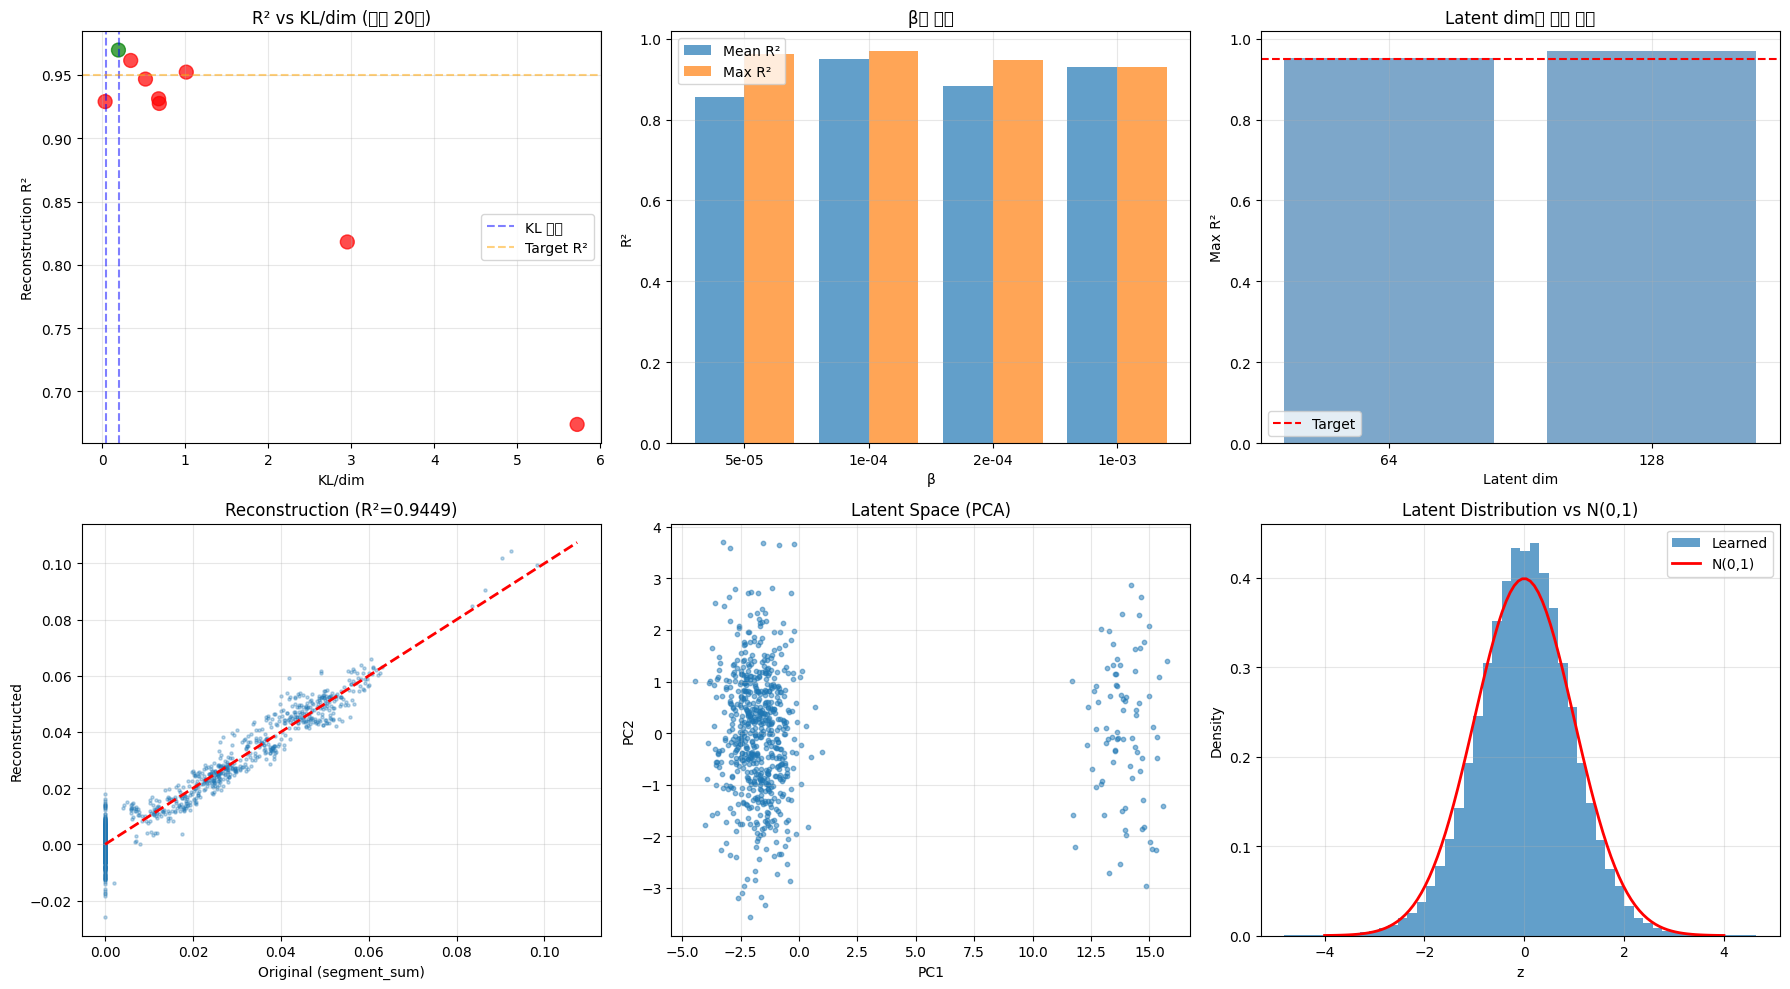


최적 설정: hidden=256, latent=128, β=1e-04, lr=2e-04
최종 Reconstruction R²: 0.9449


In [106]:
# VAE 하이퍼파라미터 탐색 결과 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 상위 결과들의 R² vs KL/dim
ax = axes[0, 0]
top_results = all_results[:20]  # 상위 20개
r2_vals = [r['recon_r2'] for r in top_results]
kl_vals = [r['kl_per_dim'] for r in top_results]
in_range = [r['in_kl_range'] for r in top_results]
colors = ['green' if ir else 'red' for ir in in_range]

ax.scatter(kl_vals, r2_vals, c=colors, s=100, alpha=0.7)
ax.axvline(x=0.05, color='blue', linestyle='--', alpha=0.5, label='KL 범위')
ax.axvline(x=0.2, color='blue', linestyle='--', alpha=0.5)
ax.axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='Target R²')
ax.set_xlabel('KL/dim')
ax.set_ylabel('Reconstruction R²')
ax.set_title('R² vs KL/dim (상위 20개)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. β별 성능 비교
ax = axes[0, 1]
beta_groups = {}
for r in all_results:
    b = r['beta']
    if b not in beta_groups:
        beta_groups[b] = []
    beta_groups[b].append(r['recon_r2'])

betas_sorted = sorted(beta_groups.keys())
beta_labels = [f'{b:.0e}' for b in betas_sorted]
beta_r2_means = [np.mean(beta_groups[b]) for b in betas_sorted]
beta_r2_maxs = [np.max(beta_groups[b]) for b in betas_sorted]

x_pos = np.arange(len(betas_sorted))
ax.bar(x_pos - 0.2, beta_r2_means, 0.4, label='Mean R²', alpha=0.7)
ax.bar(x_pos + 0.2, beta_r2_maxs, 0.4, label='Max R²', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(beta_labels)
ax.set_xlabel('β')
ax.set_ylabel('R²')
ax.set_title('β별 성능')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Latent dim별 성능 비교
ax = axes[0, 2]
latent_groups = {}
for r in all_results:
    ld = r['latent_dim']
    if ld not in latent_groups:
        latent_groups[ld] = {'r2': [], 'kl': []}
    latent_groups[ld]['r2'].append(r['recon_r2'])
    latent_groups[ld]['kl'].append(r['kl_per_dim'])

latent_sorted = sorted(latent_groups.keys())
latent_labels = [str(ld) for ld in latent_sorted]
latent_r2_maxs = [np.max(latent_groups[ld]['r2']) for ld in latent_sorted]

ax.bar(latent_labels, latent_r2_maxs, alpha=0.7, color='steelblue')
ax.axhline(y=0.95, color='red', linestyle='--', label='Target')
ax.set_xlabel('Latent dim')
ax.set_ylabel('Max R²')
ax.set_title('Latent dim별 최고 성능')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. 최적 모델 Reconstruction 품질
pretrained_vae.eval()
val_recons, val_originals = [], []
with torch.no_grad():
    for segment_sizes_batch, features_batch, _ in val_loader:
        mean, logvar, z, recon, segment_sum_vec = pretrained_vae(segment_sizes_batch, features_batch)
        val_recons.append(recon.cpu().numpy())
        val_originals.append(segment_sum_vec.cpu().numpy())

val_recons_flat = np.concatenate(val_recons).flatten()
val_originals_flat = np.concatenate(val_originals).flatten()

ax = axes[1, 0]
sample_idx = np.random.choice(len(val_originals_flat), min(5000, len(val_originals_flat)), replace=False)
ax.scatter(val_originals_flat[sample_idx], val_recons_flat[sample_idx], alpha=0.3, s=5)
ax.plot([val_originals_flat.min(), val_originals_flat.max()], 
        [val_originals_flat.min(), val_originals_flat.max()], 'r--', lw=2)
ax.set_xlabel('Original (segment_sum)')
ax.set_ylabel('Reconstructed')
final_r2 = r2_score(val_originals_flat, val_recons_flat)
ax.set_title(f'Reconstruction (R²={final_r2:.4f})')
ax.grid(True, alpha=0.3)

# 5. Latent space 시각화
all_z = []
with torch.no_grad():
    for segment_sizes_batch, features_batch, _ in val_loader:
        _, _, z, _, _ = pretrained_vae(segment_sizes_batch, features_batch)
        all_z.append(z.cpu().numpy())
all_z = np.concatenate(all_z)

ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(all_z)
ax.scatter(z_2d[:, 0], z_2d[:, 1], alpha=0.5, s=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Latent Space (PCA)')
ax.grid(True, alpha=0.3)

# 6. Latent 분포 히스토그램
ax = axes[1, 2]
ax.hist(all_z.flatten(), bins=50, density=True, alpha=0.7, label='Learned')
x = np.linspace(-4, 4, 100)
ax.plot(x, np.exp(-x**2/2) / np.sqrt(2*np.pi), 'r-', lw=2, label='N(0,1)')
ax.set_xlabel('z')
ax.set_ylabel('Density')
ax.set_title('Latent Distribution vs N(0,1)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n최적 설정: hidden={best_config['hidden_dim']}, latent={best_config['latent_dim']}, β={best_config['beta']:.0e}, lr={best_config['lr']:.0e}")
print(f"최종 Reconstruction R²: {final_r2:.4f}")

In [73]:
# # VAE 모델 저장
# import os

# # 최적 결과 찾기 (all_results의 첫 번째 항목이 최고)
# best_result = all_results[0]
# print("최적 결과:", best_result)

# # 저장 경로 설정
# save_dir = '/root/work/tenset/scripts/pre_experiments/model_final/checkpoints'
# os.makedirs(save_dir, exist_ok=True)

# # 모델 및 설정 저장
# checkpoint = {
#     'model_state_dict': pretrained_vae.state_dict(),
#     'config': {
#         'hidden_dim': best_result['hidden_dim'],
#         'latent_dim': best_result['latent_dim'],
#         'beta': best_result['beta'],
#         'lr': best_result['lr'],
#     },
#     'metrics': {
#         'recon_r2': best_result['recon_r2'],
#         'kl_per_dim': best_result['kl_per_dim'],
#         'in_kl_range': best_result['in_kl_range'],
#         'score': best_result['score']
#     },
#     'search_results': all_results[:20]  # 상위 20개 결과 저장
# }

# save_path = os.path.join(save_dir, 'vae_feature_encoder.pt')
# torch.save(checkpoint, save_path)
# print(f"\n✓ VAE 모델 저장 완료: {save_path}")
# print(f"\n저장된 설정:")
# print(f"  - Hidden dim: {checkpoint['config']['hidden_dim']}")
# print(f"  - Latent dim: {checkpoint['config']['latent_dim']}")
# print(f"  - β: {checkpoint['config']['beta']:.0e}")
# print(f"  - Learning rate: {checkpoint['config']['lr']:.0e}")
# print(f"  - Reconstruction R²: {checkpoint['metrics']['recon_r2']:.4f}")
# print(f"  - KL/dim: {checkpoint['metrics']['kl_per_dim']:.4f}")
# print(f"  - KL 범위 내: {'예' if checkpoint['metrics']['in_kl_range'] else '아니오'}")

In [107]:
# Top-10 VAE 모델 각각 저장
import os

save_dir = '/root/work/tenset/scripts/pre_experiments/model_final/checkpoints/vae_medium_v2'
os.makedirs(save_dir, exist_ok=True)

# all_results가 이미 score 기준 내림차순 정렬되어 있음
top_10_results = all_results[:3]

print("=" * 70)
print("Top-10 VAE 모델 저장")
print("=" * 70)
print(f"저장 경로: {save_dir}")
print()

for rank, result in enumerate(top_10_results, 1):
    # 파일명 생성 (설정값 포함)
    filename = f"vae_rank{rank}_h{result['hidden_dim']}_l{result['latent_dim']}_b{result['beta']:.0e}_lr{result['lr']:.0e}.pt"
    save_path = os.path.join(save_dir, filename)
    
    # 체크포인트 생성
    checkpoint = {
        'rank': rank,
        'model_state_dict': result['model'].state_dict(),
        'config': {
            'hidden_dim': result['hidden_dim'],
            'latent_dim': result['latent_dim'],
            'beta': result['beta'],
            'lr': result['lr'],
        },
        'metrics': {
            'recon_r2': result['recon_r2'],
            'kl_per_dim': result['kl_per_dim'],
            'in_kl_range': result['in_kl_range'],
            'score': result['score']
        },
        'history': result['history']
    }
    
    torch.save(checkpoint, save_path)
    
    kl_status = "✓" if result['in_kl_range'] else "✗"
    print(f"[{rank:2d}] {filename}")
    print(f"     R²={result['recon_r2']:.4f}, KL/dim={result['kl_per_dim']:.4f} {kl_status}, Score={result['score']:.4f}")

print()
print("=" * 70)
print(f"✓ Top-10 VAE 모델 저장 완료!")
print("=" * 70)

# 저장된 파일 목록 확인
print("\n저장된 파일 목록:")
for f in sorted(os.listdir(save_dir)):
    if f.startswith('vae_rank'):
        fpath = os.path.join(save_dir, f)
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  - {f} ({size_mb:.2f} MB)")

Top-10 VAE 모델 저장
저장 경로: /root/work/tenset/scripts/pre_experiments/model_final/checkpoints/vae_medium_v2

[ 1] vae_rank1_h256_l128_b1e-04_lr2e-04.pt
     R²=0.9697, KL/dim=0.1939 ✓, Score=0.9697
[ 2] vae_rank2_h256_l128_b5e-05_lr1e-03.pt
     R²=0.9615, KL/dim=0.3417 ✗, Score=0.9476
[ 3] vae_rank3_h256_l128_b1e-03_lr2e-04.pt
     R²=0.9290, KL/dim=0.0335 ✗, Score=0.8960

✓ Top-10 VAE 모델 저장 완료!

저장된 파일 목록:
  - vae_rank1_h256_l128_b1e-04_lr2e-04.pt (1.82 MB)
  - vae_rank2_h256_l128_b5e-05_lr1e-03.pt (1.82 MB)
  - vae_rank3_h256_l128_b1e-03_lr2e-04.pt (1.83 MB)


In [37]:
# 현재 all_results 개수 확인
print(f"all_results 개수: {len(all_results)}")
if len(all_results) > 0:
    print(f"\n현재 저장된 결과:")
    for i, r in enumerate(all_results[:10]):
        kl_status = "✓" if r['in_kl_range'] else "✗"
        print(f"  [{i+1}] hidden={r['hidden_dim']}, latent={r['latent_dim']}, β={r['beta']:.0e}, lr={r['lr']:.0e} | R²={r['recon_r2']:.4f}, KL/dim={r['kl_per_dim']:.4f} {kl_status}")

all_results 개수: 48

현재 저장된 결과:
  [1] hidden=128, latent=64, β=1e-04, lr=2e-04 | R²=0.9981, KL/dim=0.1039 ✓
  [2] hidden=128, latent=64, β=1e-04, lr=1e-03 | R²=0.9973, KL/dim=0.1006 ✓
  [3] hidden=128, latent=32, β=1e-04, lr=1e-03 | R²=0.9969, KL/dim=0.1740 ✓
  [4] hidden=128, latent=32, β=2e-04, lr=1e-03 | R²=0.9954, KL/dim=0.0510 ✓
  [5] hidden=256, latent=32, β=1e-04, lr=2e-04 | R²=0.9911, KL/dim=0.1483 ✓
  [6] hidden=128, latent=64, β=5e-04, lr=2e-04 | R²=0.9910, KL/dim=0.0522 ✓
  [7] hidden=128, latent=32, β=5e-04, lr=2e-04 | R²=0.9907, KL/dim=0.1017 ✓
  [8] hidden=128, latent=64, β=2e-04, lr=5e-04 | R²=0.9899, KL/dim=0.1407 ✓
  [9] hidden=128, latent=64, β=5e-04, lr=5e-04 | R²=0.9873, KL/dim=0.0657 ✓
  [10] hidden=256, latent=32, β=5e-04, lr=5e-04 | R²=0.9865, KL/dim=0.1676 ✓
